# Assignment 1: Patch Match and Texture synthesis


## Objectives

The goal of this assignment is 
- to understand and explain existing python code
- to implement (dis)similarity metrics 
- to apply them to images, patches or features and observe their influence
- to apply pacth comparison in order to estimate a nearest neighbor field between two images. This will be done using  the patch match algorithm [1] 
- to extend the use of patch match for texture synthesis.

You will be evaluated on these objectives, on the quality of your explanations and results analysis. 

[1] Barnes, Shechtman, Finkelstein and Goldman. "PatchMatch: A Randomized Correspondence Algorithm for Structural Image Editing". SIGGRAPH, 2009  

---

In [2]:
!source /net/ens/DeepLearning/python3/tensorflow2/bin/activate

In [3]:
#Import all libraries
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time


In [4]:
#function you can use to plot one image with legend
def plotImage(image, legend, figsize_=(4,4)):
    plt.figure(figsize=figsize_)
    plt.imshow(image)
    plt.axis('off')
    plt.title(legend)
    plt.show()
    
#function you can use to plot a list of images with legend
def plotImages(images, legend, figsize_=(4,4)): 
    num = len(images)
    fig, axes = plt.subplots(1,num,  figsize=figsize_)
    axes[0].set_title(legend)
    for i in range(num):  
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

## Distance between patches ##

### Question 1
Complete the functions computing similarities between two impute multi-dimensional arrays:
- Sum of Absolute Differences (SAD), i.e. L1 distance of the patch difference
- Sum of Squared Differences (SSD), i.e. L2 distance of the patch difference
- Cross-Correlation (CC)
- Zero-mean Normalized Cross-Correlation (ZNCC) 

---

In [5]:
# !!Complete these functions
#
def SSD(array1,array2):
    dist = np.sum(np.square(array1 - array2))
    return dist


def SAD(array1,array2):
    dist = np.sum(np.absolute(array1 - array2))
    return dist

def CC(array1,array2):
    m1 = np.mean(array1)
    m2 = np.mean(array2)
    arraym1 = array1 - m1
    arraym2 = array2 - m2
    dist = np.sum(arraym1 * arraym2)
    return dist

def ZNCC(array1,array2):
    a = CC(array1,array2)
    b = np.sqrt(np.var(array1)* np.var(array2))
    dist = a/b
    return dist


#Switch between different distance between patches
def distance(array1, array2, method=0):
    switcher={
            0:SSD,
            1:SAD,
            2:CC,
            3:ZNCC,
            }
    func=switcher.get(method,SSD)  #default choice=SSD
    return func(array1,array2)

distancename = ["SSD","SAD","CC","ZNCC"]

### Question 2
Test the distance functions by searching for some random patches of an image their closest patch in the same image (excepting themselves) for the different metrics.
You can test with different images



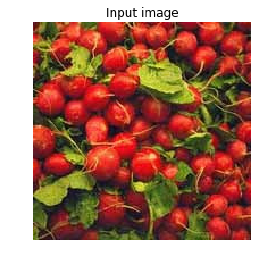

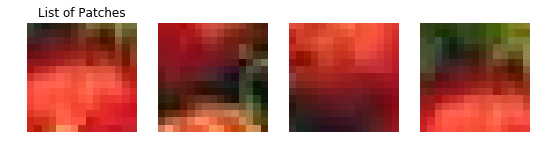

In [6]:
#Test the distance functions
# Load image
im = Image.open('text2.jpg', 'r') #You should test with other images
im = np.asarray(im)
#display image
plotImage(im, "Input image")   
#image size
shape = np.shape(im)


#Extract randomly 5 small square templates (i.e patches of size 9x9 for instance) from the texture image
num_patches = 4
p_size = 15 #You should test with other values
p_halfsize = p_size // 2
patch_list = []
x_list = []
y_list = []
for _ in range(num_patches):  
    #COMPLETE 
    #You can use function np.random.randint to get random coordinates and 
    #function np.append to append the patches to lists
    x = np.random.randint(0, shape[0] - p_size)
    y = np.random.randint(0, shape[1] - p_size)
    patch = im[x:x+p_size, y:y+p_size,:]
    patch_list.append(patch)
    x_list.append(x+p_halfsize)
    y_list.append(y+p_halfsize)

plotImages(patch_list, "List of Patches",(9,9))

#For each template, find the best matching one(s) in the full texture (excluding the tested template itself)
# with the various metrics.




#COMPLETE

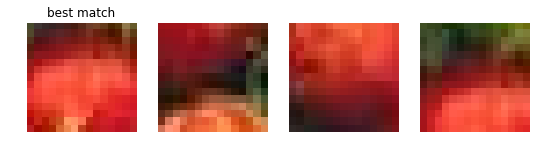

In [7]:
match_list = []
dist_list = []

for k in range(num_patches):
    dist = 0
    x = 0
    y = 0
    for i in range(p_halfsize,(shape[0] - p_halfsize-1)):
        for j in range(p_halfsize,(shape[1] - p_halfsize-1)):
            if i != x_list[k] and j!= y_list[k]:
                match = im[(i - p_halfsize):(i+p_halfsize+1),(j-p_halfsize):(j+p_halfsize+1),:]
                d = ZNCC(patch_list[k], match) #You can use CC, SAD or SSD instead of ZNCC 
                if d > dist:                   # If you use SAD or SSD, d < dist 
                    dist = d
                    x = i
                    y = j
    best_match = im[x-p_halfsize:x+p_halfsize+1, y-p_halfsize:y+p_halfsize+1,:]
    match_list.append(best_match)
    dist_list.append(dist)

plotImages(match_list, "best match", (9,9))

---


### Question 3
What other methods could you use to compute similarities?
 


---

## PatchMatch ## 
 From now, **only SSD or SAD** will be considered. 
 
### Question 4
Present the principle of the PatchMath algorithm and explain the given functions. Explain what is a nearest neighbor field and what it can be used for.

### Question 5
 1. Complete the function 'reconstruction' that copies the color from image B to image A using the nearest neighbour field (NNF) $f$. 
 2. Complete function propagation.
 3. Complete function patch match.




In [8]:
#Switch between different distance between patches and adapt the computation for patch match application
def cal_distance(coorda, coordb, A_padding, B, p_size,method=0):
    switcher={
            0:SSD,
            1:SAD
            }
    func=switcher.get(method,SSD)  #default choice=SSD 
    p = p_size // 2
    patch_a = A_padding[coorda[0]:coorda[0]+p_size, coorda[1]:coorda[1]+p_size, :]
    patch_b = B[coordb[0]-p:coordb[0]+p+1, coordb[1]-p:coordb[1]+p+1, :]
    return func(patch_a,patch_b)


def reconstruction(f, A,B):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    newA = np.zeros((A_h,A_w,3), dtype='uint8')

    for i in range(0, A_h):
        for j in range(0,A_w):
            newA[i,j:] = B[f[i,j][0], f[i,j][1],:]
    return newA


def initialization(A, B, p_size,method=0):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros((A_h, A_w,2), dtype=int)
    dist = np.zeros((A_h, A_w))
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            f[i, j,:] = b
            dist[i, j] = cal_distance(a, b, A_padding, B, p_size,method)
    return f, dist, A_padding

def propagation(f, coorda, dist, A_padding, B, p_size, is_odd,method=0):
    A_h = np.size(A_padding, 0) - p_size 
    A_w = np.size(A_padding, 1) - p_size 
    B_h = np.size(B, 0) 
    B_w = np.size(B, 1)
    i = coorda[0]
    j = coorda[1]
    p = p_size // 2
    if is_odd:

        c1 = f[i+1,j] - [1,0]
        if(c1[0] < B_h - p and c1[0] >= p):
            d1 = cal_distance([i,j], c1, A_padding, B, p_size)
        else:
            d1 = dist[i,j]  

        c2 = f[i,j+1] - [0,1]
        if(c2[1] < B_w - p and c2[1] >= p):
            d2 = cal_distance([i,j], c2, A_padding, B, p_size)
        else:
            d2 = dist[i,j]


        if d1 < d2 and d1 < dist[i,j] :
            f[i,j] = c1
            dist[i,j] = d1

        elif d2 < dist[i,j]:
            f[i,j] = c2
            dist[i,j]= d2


    else:
        c1 = f[i-1,j] + [1,0]
        if(c1[0] < B_h - p and c1[0] >= p):
            d1 = cal_distance([i,j], c1, A_padding, B, p_size)
        else:
            d1 = dist[i,j]


        c2 = f[i,j-1] + [0,1]
        if(c2[1] < B_w - p and c2[1] >= p):
            d2 = cal_distance([i,j], c2, A_padding, B, p_size)
        else:
            d2 = dist[i,j]
        
        
        if d1 < d2 and d1 < dist[i,j]:
            f[i,j] = c1
            dist[i,j] = d1
        elif d2 < dist[i,j]:
            f[i,j] = c2
            dist[i,j] = d2


    return f,dist

def random_search(f, coorda, dist, A_padding, B, p_size, alpha=0.5,method=0):
    i = coorda[0]
    j = coorda[1]
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = p_size // 2
    puis = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_i = f[i,j][0]
    b_j = f[i,j][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_i - search_h, p)
        search_max_r = min(b_i + search_h, B_h-p)
        random_b_i = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_j - search_w, p)
        search_max_c = min(b_j + search_w, B_w - p)
        random_b_j = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** puis
        search_w = B_w * alpha ** puis
        coordb = np.array([random_b_i, random_b_j])
        d = cal_distance(coorda, coordb, A_padding, B, p_size,method)
        if d < dist[i,j]:
            dist[i,j] = d
            f[i,j] = coordb
        puis += 1
    return f,dist

def PatchMatch(img, ref, p_size, nbiter,alpha=0.5,method=0):
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    f, dist, img_padding = initialization(img, ref, p_size,method)
    p = p_size//2
    for itr in range(1, nbiter+1):
        print("iteration: %d"%(itr))
        if itr % 2 == 0:
           for i in reversed(range(p,A_h-p)):
               for j in reversed(range(p,A_w-p)):
                   f,dist = propagation(f, [i,j], dist, img_padding, ref, p_size, False, method)
        else:
            for i in range(p,A_h-p):
               for j in range(p,A_w-p):
                   f, dist = propagation(f, [i,j], dist, img_padding, ref, p_size, True, method)

    return f,dist



### Question 6
Apply the method to reconstruct image "a.png" from "b.png" (using provided images), and image  "a.png" from "text2.jpg" 

In [9]:
#Code to evaluate. Modify it for your own usage
imB = Image.open('a.png', 'r')
imA = Image.open('text2.jpg', 'r')
(width, height) = (imA.width // 4, imA.height // 4)
imA = imA.resize((width, height))
(width, height) = (imB.width // 4, imB.height // 4)
imB = imB.resize((width, height))
imA = np.asarray(imA)
imB = np.asarray(imB)

method=0
alpha=0.5
f,dist = PatchMatch(imA,imB,9,30,alpha,method=0)
imC = reconstruction(f, imA,imB)

plt.imshow(imC)




FileNotFoundError: [Errno 2] No such file or directory: 'text2.png'



### Question 7
Analyze the role of the source and reference images, the influence of the size of patches, the number of iterations, the quality of the reconstrucion, the nearest neighbor field, etc. 
Try to be concise but clear on what you are evaluating